# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [86]:
# can comment out after executing
#!unzip /home/ec2-user/SageMaker/Udacity/udacitygit/deep-learning-v2-pytorch/project-face-generation/processed-celeba-small.zip


In [87]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [88]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [89]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
   
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    
    train_on_gpu = torch.cuda.is_available()

    if (torch.cuda.is_available()):
        num_workers= 4*torch.cuda.device_count()
   
    #train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
    data = datasets.ImageFolder(root=data_dir, transform=transform)
    
    # build DataLoaders for SVHN dataset
    data_loader = torch.utils.data.DataLoader(dataset=data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)
   
    
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    #                                       num_workers=num_workers)
    
    # TODO: Implement function and return a dataloader
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [90]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

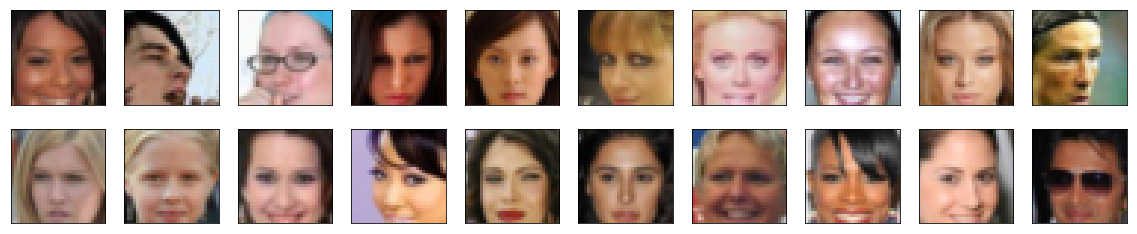

In [91]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [92]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [93]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9686)
Max:  tensor(0.6863)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [94]:
import torch.nn as nn
import torch.nn.functional as F

In [95]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        # all hidden layers + leaky relu activation
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        x = self.fc(x)        
        return x
    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [96]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

class Generator(nn.Module):
     
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        #self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
  
    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [105]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    
    std_dev = 0.02
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    


    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            m.weight.data.normal_(0.0, std_dev)
            if hasattr(m, 'bias') and m.bias is not None:
                m.bias.data.zero_()
       
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    return m

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [106]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [107]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [108]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [109]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
  
    labels = torch.ones(batch_size)*0.9
    
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    #criterion= nn.MSELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    #criterion= nn.MSELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [78]:
#def real_loss(D_out):
#    # how close is the produced output from being "real"?
#    return torch.mean((D_out-1)**2)

#def fake_loss(D_out):
#    # how close is the produced output from being "false"?
#    return torch.mean(D_out**2)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [110]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G


lr = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])



---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [111]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
        
            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
        
            # 2. Train with fake images
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
               
            g_optimizer.zero_grad()
        
            # 1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [117]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 0.4740 | g_loss: 3.4098
Epoch [    1/   50] | d_loss: 0.6100 | g_loss: 3.3018
Epoch [    1/   50] | d_loss: 0.4441 | g_loss: 3.2205
Epoch [    1/   50] | d_loss: 0.3869 | g_loss: 3.9815
Epoch [    1/   50] | d_loss: 0.4024 | g_loss: 4.2965
Epoch [    1/   50] | d_loss: 0.4108 | g_loss: 4.1385
Epoch [    1/   50] | d_loss: 0.4452 | g_loss: 4.5101
Epoch [    1/   50] | d_loss: 0.5088 | g_loss: 3.9479
Epoch [    1/   50] | d_loss: 0.3929 | g_loss: 4.0193
Epoch [    1/   50] | d_loss: 0.5205 | g_loss: 4.2948
Epoch [    1/   50] | d_loss: 0.4234 | g_loss: 2.8449
Epoch [    1/   50] | d_loss: 0.5657 | g_loss: 1.4572
Epoch [    1/   50] | d_loss: 0.6731 | g_loss: 0.9710
Epoch [    1/   50] | d_loss: 0.7009 | g_loss: 1.9690
Epoch [    1/   50] | d_loss: 0.4980 | g_loss: 3.7184
Epoch [    1/   50] | d_loss: 0.4592 | g_loss: 2.7370
Epoch [    1/   50] | d_loss: 0.4325 | g_loss: 2.8683
Epoch [    1/   50] | d_loss: 0.3768 | g_loss: 4.0445
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.4533 | g_loss: 3.2369
Epoch [    3/   50] | d_loss: 0.4383 | g_loss: 3.9899
Epoch [    3/   50] | d_loss: 0.4427 | g_loss: 3.4628
Epoch [    3/   50] | d_loss: 0.4265 | g_loss: 3.9590
Epoch [    3/   50] | d_loss: 0.7176 | g_loss: 2.0768
Epoch [    3/   50] | d_loss: 0.4767 | g_loss: 2.9249
Epoch [    3/   50] | d_loss: 0.5547 | g_loss: 4.2665
Epoch [    3/   50] | d_loss: 0.3981 | g_loss: 3.4700
Epoch [    3/   50] | d_loss: 0.4631 | g_loss: 3.0940
Epoch [    3/   50] | d_loss: 0.4358 | g_loss: 3.8764
Epoch [    3/   50] | d_loss: 0.4384 | g_loss: 4.2038
Epoch [    3/   50] | d_loss: 0.4183 | g_loss: 2.7505
Epoch [    3/   50] | d_loss: 0.4331 | g_loss: 4.1716
Epoch [    3/   50] | d_loss: 0.4342 | g_loss: 2.4870
Epoch [    3/   50] | d_loss: 0.5279 | g_loss: 1.7209
Epoch [    3/   50] | d_loss: 0.3908 | g_loss: 2.9960
Epoch [    3/   50] | d_loss: 0.4598 | g_loss: 5.0357
Epoch [    3/   50] | d_loss: 0.4282 | g_loss: 4.0317
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.5158 | g_loss: 3.1543
Epoch [    6/   50] | d_loss: 0.4409 | g_loss: 2.9264
Epoch [    6/   50] | d_loss: 0.5655 | g_loss: 2.7299
Epoch [    6/   50] | d_loss: 0.4552 | g_loss: 2.8594
Epoch [    6/   50] | d_loss: 0.3923 | g_loss: 3.5982
Epoch [    6/   50] | d_loss: 0.7385 | g_loss: 2.7743
Epoch [    6/   50] | d_loss: 0.5044 | g_loss: 3.1971
Epoch [    6/   50] | d_loss: 0.4736 | g_loss: 2.9275
Epoch [    6/   50] | d_loss: 0.5398 | g_loss: 2.2988
Epoch [    6/   50] | d_loss: 0.6687 | g_loss: 2.7851
Epoch [    6/   50] | d_loss: 0.3979 | g_loss: 4.2205
Epoch [    6/   50] | d_loss: 0.4153 | g_loss: 3.6142
Epoch [    6/   50] | d_loss: 0.4198 | g_loss: 4.2429
Epoch [    6/   50] | d_loss: 0.4071 | g_loss: 3.3820
Epoch [    6/   50] | d_loss: 0.4420 | g_loss: 3.6324
Epoch [    6/   50] | d_loss: 0.4481 | g_loss: 4.6398
Epoch [    6/   50] | d_loss: 0.3907 | g_loss: 4.3803
Epoch [    6/   50] | d_loss: 0.4971 | g_loss: 3.2609
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.4003 | g_loss: 4.1614
Epoch [    9/   50] | d_loss: 0.4525 | g_loss: 2.9105
Epoch [    9/   50] | d_loss: 0.3847 | g_loss: 4.1598
Epoch [    9/   50] | d_loss: 0.4135 | g_loss: 3.7602
Epoch [    9/   50] | d_loss: 0.4177 | g_loss: 3.5567
Epoch [    9/   50] | d_loss: 0.3882 | g_loss: 4.0947
Epoch [    9/   50] | d_loss: 0.4763 | g_loss: 2.6040
Epoch [    9/   50] | d_loss: 0.4119 | g_loss: 2.9929
Epoch [    9/   50] | d_loss: 0.4164 | g_loss: 2.8936
Epoch [    9/   50] | d_loss: 0.4480 | g_loss: 3.4946
Epoch [    9/   50] | d_loss: 0.8867 | g_loss: 2.0636
Epoch [    9/   50] | d_loss: 0.3868 | g_loss: 4.2205
Epoch [    9/   50] | d_loss: 0.3787 | g_loss: 3.6420
Epoch [    9/   50] | d_loss: 0.5219 | g_loss: 4.6694
Epoch [    9/   50] | d_loss: 0.5464 | g_loss: 4.0117
Epoch [    9/   50] | d_loss: 0.5705 | g_loss: 3.1309
Epoch [    9/   50] | d_loss: 0.6218 | g_loss: 3.0038
Epoch [    9/   50] | d_loss: 0.4853 | g_loss: 3.4815
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.4243 | g_loss: 4.1220
Epoch [   11/   50] | d_loss: 0.4405 | g_loss: 3.6204
Epoch [   11/   50] | d_loss: 0.4955 | g_loss: 3.0975
Epoch [   11/   50] | d_loss: 0.3876 | g_loss: 3.5623
Epoch [   11/   50] | d_loss: 0.3919 | g_loss: 3.8369
Epoch [   11/   50] | d_loss: 0.3894 | g_loss: 3.3419
Epoch [   11/   50] | d_loss: 0.4828 | g_loss: 3.5163
Epoch [   11/   50] | d_loss: 0.4046 | g_loss: 3.2714
Epoch [   11/   50] | d_loss: 0.3970 | g_loss: 3.3809
Epoch [   11/   50] | d_loss: 0.4485 | g_loss: 3.7612
Epoch [   11/   50] | d_loss: 0.5602 | g_loss: 2.6663
Epoch [   11/   50] | d_loss: 0.5439 | g_loss: 2.9261
Epoch [   11/   50] | d_loss: 0.3897 | g_loss: 3.8869
Epoch [   11/   50] | d_loss: 0.4550 | g_loss: 3.1309
Epoch [   11/   50] | d_loss: 0.3776 | g_loss: 4.3880
Epoch [   11/   50] | d_loss: 0.3941 | g_loss: 4.5483
Epoch [   11/   50] | d_loss: 0.3913 | g_loss: 2.2288
Epoch [   11/   50] | d_loss: 0.3807 | g_loss: 3.6124
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.5112 | g_loss: 2.3401
Epoch [   14/   50] | d_loss: 0.4723 | g_loss: 3.6432
Epoch [   14/   50] | d_loss: 0.4794 | g_loss: 3.8151
Epoch [   14/   50] | d_loss: 0.4639 | g_loss: 3.6173
Epoch [   14/   50] | d_loss: 0.4013 | g_loss: 4.4663
Epoch [   14/   50] | d_loss: 0.4292 | g_loss: 4.0666
Epoch [   14/   50] | d_loss: 0.4193 | g_loss: 3.0380
Epoch [   14/   50] | d_loss: 0.4867 | g_loss: 2.4776
Epoch [   14/   50] | d_loss: 0.4702 | g_loss: 2.6444
Epoch [   14/   50] | d_loss: 0.4285 | g_loss: 3.7183
Epoch [   14/   50] | d_loss: 0.3804 | g_loss: 4.3177
Epoch [   14/   50] | d_loss: 0.4193 | g_loss: 4.4517
Epoch [   14/   50] | d_loss: 0.3976 | g_loss: 3.5763
Epoch [   14/   50] | d_loss: 0.4480 | g_loss: 3.7246
Epoch [   14/   50] | d_loss: 0.7354 | g_loss: 1.1957
Epoch [   14/   50] | d_loss: 0.4047 | g_loss: 3.3676
Epoch [   14/   50] | d_loss: 0.4547 | g_loss: 3.1619
Epoch [   14/   50] | d_loss: 0.4130 | g_loss: 3.0857
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.4005 | g_loss: 4.3579
Epoch [   17/   50] | d_loss: 0.4882 | g_loss: 3.9884
Epoch [   17/   50] | d_loss: 0.5366 | g_loss: 3.6023
Epoch [   17/   50] | d_loss: 0.4520 | g_loss: 4.3802
Epoch [   17/   50] | d_loss: 0.3998 | g_loss: 2.2382
Epoch [   17/   50] | d_loss: 0.3836 | g_loss: 3.5787
Epoch [   17/   50] | d_loss: 0.3801 | g_loss: 2.3691
Epoch [   17/   50] | d_loss: 0.4515 | g_loss: 3.6294
Epoch [   17/   50] | d_loss: 0.4567 | g_loss: 3.0435
Epoch [   17/   50] | d_loss: 0.4842 | g_loss: 4.3302
Epoch [   17/   50] | d_loss: 0.3952 | g_loss: 5.0740
Epoch [   17/   50] | d_loss: 0.6172 | g_loss: 3.2778
Epoch [   17/   50] | d_loss: 0.3700 | g_loss: 3.5559
Epoch [   17/   50] | d_loss: 0.3821 | g_loss: 4.4486
Epoch [   17/   50] | d_loss: 0.4310 | g_loss: 3.6341
Epoch [   17/   50] | d_loss: 0.4466 | g_loss: 3.5458
Epoch [   17/   50] | d_loss: 0.7935 | g_loss: 2.4958
Epoch [   17/   50] | d_loss: 0.5686 | g_loss: 3.5087
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.3992 | g_loss: 3.6758
Epoch [   19/   50] | d_loss: 0.5029 | g_loss: 3.1622
Epoch [   19/   50] | d_loss: 0.3802 | g_loss: 3.8987
Epoch [   19/   50] | d_loss: 0.4154 | g_loss: 3.2296
Epoch [   19/   50] | d_loss: 0.4767 | g_loss: 2.9342
Epoch [   19/   50] | d_loss: 0.5487 | g_loss: 3.4942
Epoch [   19/   50] | d_loss: 0.3703 | g_loss: 4.2390
Epoch [   19/   50] | d_loss: 0.4224 | g_loss: 3.5809
Epoch [   19/   50] | d_loss: 0.4451 | g_loss: 3.2617
Epoch [   19/   50] | d_loss: 0.4637 | g_loss: 3.3504
Epoch [   19/   50] | d_loss: 0.5425 | g_loss: 3.5421
Epoch [   19/   50] | d_loss: 0.4130 | g_loss: 3.5038
Epoch [   19/   50] | d_loss: 0.6428 | g_loss: 4.4492
Epoch [   19/   50] | d_loss: 0.3791 | g_loss: 5.3077
Epoch [   19/   50] | d_loss: 0.3894 | g_loss: 4.2868
Epoch [   19/   50] | d_loss: 0.4031 | g_loss: 3.5207
Epoch [   19/   50] | d_loss: 0.4075 | g_loss: 4.1324
Epoch [   19/   50] | d_loss: 0.3622 | g_loss: 4.9701
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.4697 | g_loss: 3.4518
Epoch [   22/   50] | d_loss: 0.5613 | g_loss: 3.5544
Epoch [   22/   50] | d_loss: 0.4062 | g_loss: 4.9793
Epoch [   22/   50] | d_loss: 0.4011 | g_loss: 4.3447
Epoch [   22/   50] | d_loss: 0.4168 | g_loss: 4.0111
Epoch [   22/   50] | d_loss: 0.5440 | g_loss: 3.1342
Epoch [   22/   50] | d_loss: 0.8322 | g_loss: 1.1540
Epoch [   22/   50] | d_loss: 0.4153 | g_loss: 3.2163
Epoch [   22/   50] | d_loss: 0.3960 | g_loss: 4.4199
Epoch [   22/   50] | d_loss: 0.3674 | g_loss: 4.2366
Epoch [   22/   50] | d_loss: 0.3757 | g_loss: 4.2150
Epoch [   22/   50] | d_loss: 0.4114 | g_loss: 2.7218
Epoch [   22/   50] | d_loss: 0.3882 | g_loss: 4.2021
Epoch [   22/   50] | d_loss: 0.3835 | g_loss: 3.6602
Epoch [   22/   50] | d_loss: 0.3716 | g_loss: 4.5706
Epoch [   22/   50] | d_loss: 0.3595 | g_loss: 4.9371
Epoch [   22/   50] | d_loss: 0.4515 | g_loss: 3.3934
Epoch [   22/   50] | d_loss: 0.3783 | g_loss: 4.9595
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.4708 | g_loss: 4.7654
Epoch [   25/   50] | d_loss: 0.4164 | g_loss: 4.0494
Epoch [   25/   50] | d_loss: 0.3671 | g_loss: 4.3472
Epoch [   25/   50] | d_loss: 0.3644 | g_loss: 4.0864
Epoch [   25/   50] | d_loss: 0.4241 | g_loss: 3.6400
Epoch [   25/   50] | d_loss: 0.3638 | g_loss: 4.0790
Epoch [   25/   50] | d_loss: 0.3887 | g_loss: 4.0874
Epoch [   25/   50] | d_loss: 0.3813 | g_loss: 3.9571
Epoch [   25/   50] | d_loss: 0.4211 | g_loss: 3.7496
Epoch [   25/   50] | d_loss: 0.3945 | g_loss: 3.2862
Epoch [   25/   50] | d_loss: 0.3851 | g_loss: 4.3055
Epoch [   25/   50] | d_loss: 0.3953 | g_loss: 3.9154
Epoch [   25/   50] | d_loss: 0.3815 | g_loss: 5.0488
Epoch [   25/   50] | d_loss: 0.3912 | g_loss: 4.2486
Epoch [   25/   50] | d_loss: 0.4010 | g_loss: 3.3778
Epoch [   25/   50] | d_loss: 0.4007 | g_loss: 3.8593
Epoch [   25/   50] | d_loss: 0.3943 | g_loss: 4.3845
Epoch [   25/   50] | d_loss: 0.4079 | g_loss: 4.6215
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.4366 | g_loss: 2.7745
Epoch [   27/   50] | d_loss: 0.3888 | g_loss: 3.4129
Epoch [   27/   50] | d_loss: 0.4405 | g_loss: 4.2313
Epoch [   27/   50] | d_loss: 0.3695 | g_loss: 3.6091
Epoch [   27/   50] | d_loss: 0.3963 | g_loss: 4.1591
Epoch [   27/   50] | d_loss: 0.3923 | g_loss: 4.3558
Epoch [   27/   50] | d_loss: 0.3831 | g_loss: 2.9185
Epoch [   27/   50] | d_loss: 0.3808 | g_loss: 2.8678
Epoch [   27/   50] | d_loss: 0.4090 | g_loss: 4.4470
Epoch [   27/   50] | d_loss: 0.4655 | g_loss: 3.3747
Epoch [   27/   50] | d_loss: 0.3991 | g_loss: 4.6873
Epoch [   27/   50] | d_loss: 0.3773 | g_loss: 4.7294
Epoch [   27/   50] | d_loss: 0.4324 | g_loss: 4.2747
Epoch [   27/   50] | d_loss: 0.4325 | g_loss: 3.0852
Epoch [   27/   50] | d_loss: 0.4869 | g_loss: 3.1013
Epoch [   27/   50] | d_loss: 0.3994 | g_loss: 3.4602
Epoch [   27/   50] | d_loss: 0.3899 | g_loss: 4.0854
Epoch [   27/   50] | d_loss: 0.3798 | g_loss: 4.4407
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.4867 | g_loss: 3.3886
Epoch [   30/   50] | d_loss: 0.3758 | g_loss: 3.2965
Epoch [   30/   50] | d_loss: 0.4265 | g_loss: 4.3314
Epoch [   30/   50] | d_loss: 0.3930 | g_loss: 4.3181
Epoch [   30/   50] | d_loss: 0.5231 | g_loss: 2.6703
Epoch [   30/   50] | d_loss: 0.4507 | g_loss: 1.9128
Epoch [   30/   50] | d_loss: 0.3827 | g_loss: 4.0085
Epoch [   30/   50] | d_loss: 0.3965 | g_loss: 4.0312
Epoch [   30/   50] | d_loss: 0.3878 | g_loss: 5.1853
Epoch [   30/   50] | d_loss: 0.4158 | g_loss: 2.7399
Epoch [   30/   50] | d_loss: 0.4281 | g_loss: 3.8090
Epoch [   30/   50] | d_loss: 0.3718 | g_loss: 4.3550
Epoch [   30/   50] | d_loss: 0.4110 | g_loss: 4.0043
Epoch [   30/   50] | d_loss: 0.4667 | g_loss: 3.7979
Epoch [   30/   50] | d_loss: 0.4005 | g_loss: 2.9005
Epoch [   30/   50] | d_loss: 0.4400 | g_loss: 4.7806
Epoch [   30/   50] | d_loss: 0.5936 | g_loss: 3.5023
Epoch [   30/   50] | d_loss: 0.4128 | g_loss: 4.1958
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.4746 | g_loss: 4.8370
Epoch [   33/   50] | d_loss: 0.5021 | g_loss: 2.9054
Epoch [   33/   50] | d_loss: 0.4281 | g_loss: 3.3394
Epoch [   33/   50] | d_loss: 0.3749 | g_loss: 3.1769
Epoch [   33/   50] | d_loss: 0.5384 | g_loss: 2.9260
Epoch [   33/   50] | d_loss: 0.5386 | g_loss: 3.1083
Epoch [   33/   50] | d_loss: 0.3754 | g_loss: 3.4681
Epoch [   33/   50] | d_loss: 0.4944 | g_loss: 3.7857
Epoch [   33/   50] | d_loss: 0.4102 | g_loss: 4.3540
Epoch [   33/   50] | d_loss: 0.3807 | g_loss: 4.9372
Epoch [   33/   50] | d_loss: 0.4138 | g_loss: 2.9294
Epoch [   33/   50] | d_loss: 0.4871 | g_loss: 3.3040
Epoch [   33/   50] | d_loss: 0.3577 | g_loss: 5.2260
Epoch [   33/   50] | d_loss: 0.3822 | g_loss: 3.6622
Epoch [   33/   50] | d_loss: 0.4039 | g_loss: 5.4896
Epoch [   33/   50] | d_loss: 0.4287 | g_loss: 3.3576
Epoch [   33/   50] | d_loss: 0.3915 | g_loss: 4.0834
Epoch [   33/   50] | d_loss: 0.3897 | g_loss: 4.0427
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.4047 | g_loss: 3.2696
Epoch [   35/   50] | d_loss: 0.4118 | g_loss: 5.3321
Epoch [   35/   50] | d_loss: 0.5192 | g_loss: 3.6463
Epoch [   35/   50] | d_loss: 0.4487 | g_loss: 4.7582
Epoch [   35/   50] | d_loss: 0.4041 | g_loss: 4.4874
Epoch [   35/   50] | d_loss: 0.5355 | g_loss: 2.7645
Epoch [   35/   50] | d_loss: 0.3924 | g_loss: 4.1818
Epoch [   35/   50] | d_loss: 0.3911 | g_loss: 4.3341
Epoch [   35/   50] | d_loss: 0.3990 | g_loss: 4.4334
Epoch [   35/   50] | d_loss: 0.3861 | g_loss: 3.5399
Epoch [   35/   50] | d_loss: 0.3913 | g_loss: 3.2502
Epoch [   35/   50] | d_loss: 0.3705 | g_loss: 4.6845
Epoch [   35/   50] | d_loss: 0.3980 | g_loss: 3.5385
Epoch [   35/   50] | d_loss: 0.4756 | g_loss: 3.2604
Epoch [   35/   50] | d_loss: 0.3836 | g_loss: 4.8301
Epoch [   35/   50] | d_loss: 0.3628 | g_loss: 5.6033
Epoch [   35/   50] | d_loss: 0.3739 | g_loss: 5.7371
Epoch [   35/   50] | d_loss: 0.3739 | g_loss: 4.3736
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.4260 | g_loss: 4.8026
Epoch [   38/   50] | d_loss: 0.4081 | g_loss: 4.3494
Epoch [   38/   50] | d_loss: 0.4262 | g_loss: 3.0232
Epoch [   38/   50] | d_loss: 0.4753 | g_loss: 3.4087
Epoch [   38/   50] | d_loss: 0.4376 | g_loss: 2.8409
Epoch [   38/   50] | d_loss: 0.4110 | g_loss: 3.2173
Epoch [   38/   50] | d_loss: 0.3828 | g_loss: 4.2645
Epoch [   38/   50] | d_loss: 0.4019 | g_loss: 3.8887
Epoch [   38/   50] | d_loss: 0.3586 | g_loss: 5.3420
Epoch [   38/   50] | d_loss: 0.4462 | g_loss: 3.1771
Epoch [   38/   50] | d_loss: 0.4251 | g_loss: 4.1783
Epoch [   38/   50] | d_loss: 0.4087 | g_loss: 4.1928
Epoch [   38/   50] | d_loss: 0.3732 | g_loss: 4.5020
Epoch [   38/   50] | d_loss: 0.4362 | g_loss: 3.4690
Epoch [   38/   50] | d_loss: 0.4166 | g_loss: 4.2768
Epoch [   38/   50] | d_loss: 0.4415 | g_loss: 2.6875
Epoch [   38/   50] | d_loss: 0.4085 | g_loss: 3.1515
Epoch [   38/   50] | d_loss: 0.4085 | g_loss: 3.0004
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.6690 | g_loss: 3.7364
Epoch [   41/   50] | d_loss: 0.5157 | g_loss: 3.7960
Epoch [   41/   50] | d_loss: 0.5039 | g_loss: 3.7055
Epoch [   41/   50] | d_loss: 0.4267 | g_loss: 3.3956
Epoch [   41/   50] | d_loss: 0.3914 | g_loss: 4.2822
Epoch [   41/   50] | d_loss: 0.3790 | g_loss: 3.3839
Epoch [   41/   50] | d_loss: 0.4075 | g_loss: 4.2816
Epoch [   41/   50] | d_loss: 0.3837 | g_loss: 4.4240
Epoch [   41/   50] | d_loss: 0.3781 | g_loss: 3.8550
Epoch [   41/   50] | d_loss: 0.3874 | g_loss: 4.1010
Epoch [   41/   50] | d_loss: 0.3778 | g_loss: 3.9698
Epoch [   41/   50] | d_loss: 0.5386 | g_loss: 2.5431
Epoch [   41/   50] | d_loss: 0.3817 | g_loss: 4.5990
Epoch [   41/   50] | d_loss: 0.3930 | g_loss: 5.0849
Epoch [   41/   50] | d_loss: 0.3787 | g_loss: 5.1499
Epoch [   41/   50] | d_loss: 0.4271 | g_loss: 4.7477
Epoch [   41/   50] | d_loss: 0.3562 | g_loss: 5.4554
Epoch [   41/   50] | d_loss: 0.6046 | g_loss: 3.8591
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.3867 | g_loss: 3.9544
Epoch [   43/   50] | d_loss: 0.3705 | g_loss: 4.0500
Epoch [   43/   50] | d_loss: 0.3728 | g_loss: 4.7307
Epoch [   43/   50] | d_loss: 0.4594 | g_loss: 3.2060
Epoch [   43/   50] | d_loss: 0.4137 | g_loss: 3.8841
Epoch [   43/   50] | d_loss: 0.4313 | g_loss: 4.9749
Epoch [   43/   50] | d_loss: 0.3825 | g_loss: 4.0911
Epoch [   43/   50] | d_loss: 0.3789 | g_loss: 4.3368
Epoch [   43/   50] | d_loss: 0.3847 | g_loss: 3.7718
Epoch [   43/   50] | d_loss: 0.4756 | g_loss: 4.0824
Epoch [   43/   50] | d_loss: 0.5974 | g_loss: 1.8922
Epoch [   43/   50] | d_loss: 0.5263 | g_loss: 4.8312
Epoch [   43/   50] | d_loss: 0.4339 | g_loss: 4.0508
Epoch [   43/   50] | d_loss: 1.1376 | g_loss: 3.3275
Epoch [   43/   50] | d_loss: 0.3923 | g_loss: 3.9034
Epoch [   43/   50] | d_loss: 0.3961 | g_loss: 3.7594
Epoch [   43/   50] | d_loss: 0.4033 | g_loss: 4.5231
Epoch [   43/   50] | d_loss: 0.5864 | g_loss: 4.0068
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.3531 | g_loss: 5.0355
Epoch [   46/   50] | d_loss: 0.3692 | g_loss: 4.2160
Epoch [   46/   50] | d_loss: 0.4105 | g_loss: 3.6486
Epoch [   46/   50] | d_loss: 0.3774 | g_loss: 4.7685
Epoch [   46/   50] | d_loss: 0.4050 | g_loss: 4.3497
Epoch [   46/   50] | d_loss: 0.4361 | g_loss: 3.6596
Epoch [   46/   50] | d_loss: 0.3923 | g_loss: 3.2269
Epoch [   46/   50] | d_loss: 0.3759 | g_loss: 4.1220
Epoch [   46/   50] | d_loss: 0.3741 | g_loss: 3.7280
Epoch [   46/   50] | d_loss: 0.4371 | g_loss: 3.8112
Epoch [   46/   50] | d_loss: 0.3759 | g_loss: 4.1280
Epoch [   46/   50] | d_loss: 0.3722 | g_loss: 4.2873
Epoch [   46/   50] | d_loss: 0.4554 | g_loss: 4.5899
Epoch [   46/   50] | d_loss: 0.4999 | g_loss: 3.5884
Epoch [   46/   50] | d_loss: 0.6370 | g_loss: 3.1455
Epoch [   46/   50] | d_loss: 0.4339 | g_loss: 4.3166
Epoch [   46/   50] | d_loss: 0.3776 | g_loss: 3.2641
Epoch [   46/   50] | d_loss: 0.3973 | g_loss: 3.3461
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.4236 | g_loss: 4.3303
Epoch [   49/   50] | d_loss: 0.4178 | g_loss: 4.1578
Epoch [   49/   50] | d_loss: 0.3817 | g_loss: 4.0633
Epoch [   49/   50] | d_loss: 0.4411 | g_loss: 3.3452
Epoch [   49/   50] | d_loss: 0.4328 | g_loss: 3.4682
Epoch [   49/   50] | d_loss: 0.4105 | g_loss: 3.8613
Epoch [   49/   50] | d_loss: 0.3785 | g_loss: 4.4292
Epoch [   49/   50] | d_loss: 0.3879 | g_loss: 4.9448
Epoch [   49/   50] | d_loss: 0.4261 | g_loss: 3.3959
Epoch [   49/   50] | d_loss: 0.3758 | g_loss: 4.2689
Epoch [   49/   50] | d_loss: 0.4258 | g_loss: 4.4744
Epoch [   49/   50] | d_loss: 0.3727 | g_loss: 4.5560
Epoch [   49/   50] | d_loss: 0.4815 | g_loss: 3.4147
Epoch [   49/   50] | d_loss: 0.4655 | g_loss: 3.6336
Epoch [   49/   50] | d_loss: 0.4150 | g_loss: 4.4084
Epoch [   49/   50] | d_loss: 0.4437 | g_loss: 2.3415
Epoch [   49/   50] | d_loss: 0.3709 | g_loss: 4.4439
Epoch [   49/   50] | d_loss: 0.3852 | g_loss: 4.5451
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

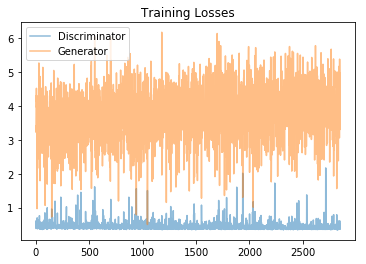

In [118]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [119]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [120]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

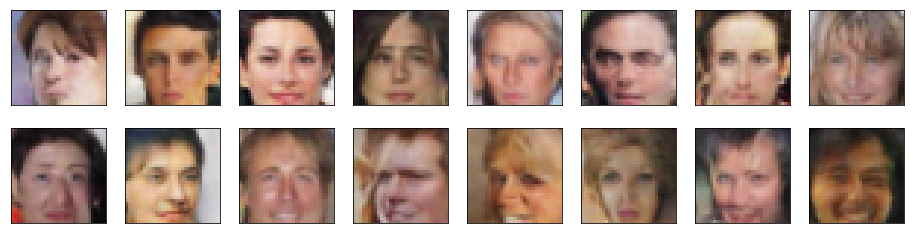

In [121]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

- Since dataset is biased having faces that are mostly white, it can only generate face of white. If we can add other races this would generate more diverse races. 

- We have resized image to 64x64 and resized to 32x32. If we can have larger image size we can use more number of conv. layaers to more number of extract features, even though more computing powers may requires. 

- Epoch: I have tried epoch number of 30,50, 100. Epoch number of 30 seems to be reasonable.
- Optimizer:  I have tried cross entropy & least squares error loss. but cross entropy gave me better results.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.